In [0]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
import datetime 
%matplotlib inline

# Load Data

In [4]:
interventions_df = pd.read_csv('http://donnees.ville.montreal.qc.ca/dataset/701683f0-a838-4fe0-b4d6-a4964d9ea7f0/resource/9e67d2f3-9104-4af4-aac4-022df621a749/download/donneesouvertes-interventions-sim.csv', sep=",")
interventions_df['CREATION_DATE_TIME'] = interventions_df['CREATION_DATE_TIME'].astype('datetime64[ns]')  
interventions_df.head()

,INCIDENT_NBR,CREATION_DATE_TIME,INCIDENT_TYPE_DESC,DESCRIPTION_GROUPE,CASERNE,NOM_VILLE,NOM_ARROND,DIVISION,NOMBRE_UNITES,CIV,MTM8_X,MTM8_Y,LONGITUDE,LATITUDE
0,1168,2015-01-03 20:56:02,Premier répondant,1-REPOND,33,Montréal,Sud-Ouest,8,1.0,1.0,297283.0,5035433.1,-73.596117,45.458786
1,1171,2015-01-03 21:03:52,Alarme privé ou locale,Alarmes-incendies,22,Montréal,Saint-Léonard,4,4.0,1.0,299180.0,5049284.2,-73.572020,45.583442
2,1172,2015-01-03 21:07:00,Premier répondant,1-REPOND,9,Montréal,Villeray / St-Michel / Parc Extension,4,1.0,1.0,297259.6,5046768.2,-73.596589,45.560784
3,1177,2015-01-03 21:41:46,Premier répondant,1-REPOND,37,Montréal,Villeray / St-Michel / Parc Extension,4,1.0,1.0,294738.3,5044817.2,-73.628847,45.543197
4,1178,2015-01-03 21:43:32,Aliments surchauffés,SANS FEU,16,Montréal,Plateau Mont-Royal,11,5.0,1.0,298505.7,5042556.1,-73.580573,45.522895


In [5]:
weather_data = pd.read_csv('weather.csv', encoding='iso-8859-1')
weather_data.head()

,Date/Time,Year,Month,Day,Data Quality,Max Temp (°C),Max Temp Flag,Min Temp (°C),Min Temp Flag,Mean Temp (°C),Mean Temp Flag,Heat Deg Days (°C),Heat Deg Days Flag,Cool Deg Days (°C),Cool Deg Days Flag,Total Rain (mm),Total Rain Flag,Total Snow (cm),Total Snow Flag,Total Precip (mm),Total Precip Flag,Snow on Grnd (cm),Snow on Grnd Flag,Dir of Max Gust (10s deg),Dir of Max Gust Flag,Spd of Max Gust (km/h),Spd of Max Gust Flag
0,2015-01-01,2015,1,1,NaN,-3.1,NaN,-7.6,NaN,-5.4,NaN,23.4,NaN,0.0,NaN,NaN,M,NaN,M,NaN,M,NaN,NaN,22.0,NaN,41,NaN
1,2015-01-02,2015,1,2,NaN,-3.4,NaN,-13.1,NaN,-8.3,NaN,26.3,NaN,0.0,NaN,NaN,M,NaN,M,NaN,M,NaN,NaN,NaN,NaN,<31,NaN
2,2015-01-03,2015,1,3,NaN,-8.0,NaN,-15.0,NaN,-11.5,NaN,29.5,NaN,0.0,NaN,NaN,M,NaN,M,NaN,M,NaN,NaN,NaN,NaN,<31,NaN
3,2015-01-04,2015,1,4,NaN,3.3,NaN,-8.1,NaN,-2.4,NaN,20.4,NaN,0.0,NaN,NaN,M,NaN,M,NaN,M,NaN,NaN,19.0,NaN,37,NaN
4,2015-01-05,2015,1,5,NaN,-4.8,NaN,-17.5,NaN,-11.2,NaN,29.2,NaN,0.0,NaN,NaN,M,NaN,M,NaN,M,NaN,NaN,18.0,NaN,44,NaN


# Preprocess Data

In [6]:
interventions_df['NOM_ARROND'] = np.where(interventions_df['NOM_ARROND'] == 'Indéterminé', interventions_df['NOM_VILLE'], interventions_df['NOM_ARROND']) 
interventions_df.head()

,INCIDENT_NBR,CREATION_DATE_TIME,INCIDENT_TYPE_DESC,DESCRIPTION_GROUPE,CASERNE,NOM_VILLE,NOM_ARROND,DIVISION,NOMBRE_UNITES,CIV,MTM8_X,MTM8_Y,LONGITUDE,LATITUDE
0,1168,2015-01-03 20:56:02,Premier répondant,1-REPOND,33,Montréal,Sud-Ouest,8,1.0,1.0,297283.0,5035433.1,-73.596117,45.458786
1,1171,2015-01-03 21:03:52,Alarme privé ou locale,Alarmes-incendies,22,Montréal,Saint-Léonard,4,4.0,1.0,299180.0,5049284.2,-73.572020,45.583442
2,1172,2015-01-03 21:07:00,Premier répondant,1-REPOND,9,Montréal,Villeray / St-Michel / Parc Extension,4,1.0,1.0,297259.6,5046768.2,-73.596589,45.560784
3,1177,2015-01-03 21:41:46,Premier répondant,1-REPOND,37,Montréal,Villeray / St-Michel / Parc Extension,4,1.0,1.0,294738.3,5044817.2,-73.628847,45.543197
4,1178,2015-01-03 21:43:32,Aliments surchauffés,SANS FEU,16,Montréal,Plateau Mont-Royal,11,5.0,1.0,298505.7,5042556.1,-73.580573,45.522895


# Feature Engineering: Creating Target Variable

In [0]:
fire_types = [
'10-22 avec feu',
'Feu de champ *',
'Ac.vic. feu train/m√©tro F7/DES',
'Acc. sans vict. av. feu - ext.',
'Acc. sans vict. av. feu-tunnel',
'Acc. s-vict. av. feu - pont',
'Acc. s-vict. av. feu - v.r.',
'Acc. s-vict. av. feu-b√¢timent',
'Acc. s-vict. feu - train/m√©tro',
'Acc. vict. feu - tunnel F7/MOU',
'Acc. victime feu - b√¢timent',
'Acc. victime feu - pont',
'Acc. victime feu - voie rapide',
'Acc. victime feu ext.',
'D√©chets en feu',
'Feu / 2e Alerte',
'Feu / 3e Alerte',
'Feu / 4e Alerte',
'Feu / 5e Alerte',
'Feu / Agravation possible',
'Feu d\'auto (voie rapide)',
'Feu de b√¢timent',
'Feu de chemin√©e *',
'Feu de cuisson',
'Feu de nature √©lectrique',
'Feu de navire/b√¢teau',
'Feu de v√©hicule ext√©rieur',
'Feu de v√©hicule int√©rieur',
'Feu de v√©hicule sur pont',
'feu de v√©hicule tunnel F7/MOU',
'Feu v√©h. convoi (train/m√©tro)',
'M√©tro b√¢timent /10-22 avec feu',
'M√©tro b√¢timent /10-22 sans feu',
'Senteur de feu √† l\'ext√©rieur]']

interventions_df['IS_FIRE'] = interventions_df['INCIDENT_TYPE_DESC'].isin(fire_types)

In [8]:
interventions_df.head()

,INCIDENT_NBR,CREATION_DATE_TIME,INCIDENT_TYPE_DESC,DESCRIPTION_GROUPE,CASERNE,NOM_VILLE,NOM_ARROND,DIVISION,NOMBRE_UNITES,CIV,MTM8_X,MTM8_Y,LONGITUDE,LATITUDE,IS_FIRE
0,1168,2015-01-03 20:56:02,Premier répondant,1-REPOND,33,Montréal,Sud-Ouest,8,1.0,1.0,297283.0,5035433.1,-73.596117,45.458786,False
1,1171,2015-01-03 21:03:52,Alarme privé ou locale,Alarmes-incendies,22,Montréal,Saint-Léonard,4,4.0,1.0,299180.0,5049284.2,-73.572020,45.583442,False
2,1172,2015-01-03 21:07:00,Premier répondant,1-REPOND,9,Montréal,Villeray / St-Michel / Parc Extension,4,1.0,1.0,297259.6,5046768.2,-73.596589,45.560784,False
3,1177,2015-01-03 21:41:46,Premier répondant,1-REPOND,37,Montréal,Villeray / St-Michel / Parc Extension,4,1.0,1.0,294738.3,5044817.2,-73.628847,45.543197,False
4,1178,2015-01-03 21:43:32,Aliments surchauffés,SANS FEU,16,Montréal,Plateau Mont-Royal,11,5.0,1.0,298505.7,5042556.1,-73.580573,45.522895,False


# # Feature Engineering: Create Time Bucket

In [0]:
import holidays
ca_holidays = holidays.CountryHoliday('CA', prov='QC', state=None)

In [10]:
interventions_df['Day'] = pd.DatetimeIndex(interventions_df['CREATION_DATE_TIME']).day
interventions_df['Month'] = pd.DatetimeIndex(interventions_df['CREATION_DATE_TIME']).month
interventions_df['Year'] = pd.DatetimeIndex(interventions_df['CREATION_DATE_TIME']).year
interventions_df['DayOfWeek'] = pd.DatetimeIndex(interventions_df['CREATION_DATE_TIME']).dayofweek
interventions_df['Time1'] = pd.DatetimeIndex(interventions_df['CREATION_DATE_TIME']).time
interventions_df['Time2'] = '1970-01-01T' + interventions_df['Time1'].map(str)
interventions_df['Time3'] = interventions_df['Time2'].apply(lambda x: np.datetime64(x))
interventions_df['Time4'] = (interventions_df['Time3'] - np.datetime64('1970-01-01 00:00:00')).apply(lambda x: x.total_seconds())
bins = [0, 10800, 21600, 32400, 43200, 54000, 64800,75600.0, 86400.0]
interventions_df['Holiday'] = interventions_df['CREATION_DATE_TIME'].apply(lambda x: x in ca_holidays)
interventions_df['Weekend'] = interventions_df['DayOfWeek'] >= 5
interventions_df['TIME_BUCKET'] = np.searchsorted(bins, interventions_df['Time4'].values)
interventions_df = pd.merge(interventions_df, weather_data,  how='inner', left_on=['Day','Month','Year'], right_on = ['Day','Month','Year'])
interventions_df.head()

,INCIDENT_NBR,CREATION_DATE_TIME,INCIDENT_TYPE_DESC,DESCRIPTION_GROUPE,CASERNE,NOM_VILLE,NOM_ARROND,DIVISION,NOMBRE_UNITES,CIV,MTM8_X,MTM8_Y,LONGITUDE,LATITUDE,IS_FIRE,Day,Month,Year,DayOfWeek,Time1,Time2,Time3,Time4,Holiday,Weekend,TIME_BUCKET,Date/Time,Data Quality,Max Temp (°C),Max Temp Flag,Min Temp (°C),Min Temp Flag,Mean Temp (°C),Mean Temp Flag,Heat Deg Days (°C),Heat Deg Days Flag,Cool Deg Days (°C),Cool Deg Days Flag,Total Rain (mm),Total Rain Flag,Total Snow (cm),Total Snow Flag,Total Precip (mm),Total Precip Flag,Snow on Grnd (cm),Snow on Grnd Flag,Dir of Max Gust (10s deg),Dir of Max Gust Flag,Spd of Max Gust (km/h),Spd of Max Gust Flag
0,1168,2015-01-03 20:56:02,Premier répondant,1-REPOND,33,Montréal,Sud-Ouest,8,1.0,1.0,297283.0,5035433.1,-73.596117,45.458786,False,3,1,2015,5,20:56:02,1970-01-01T20:56:02,1970-01-01 20:56:02,75362.0,False,True,7,2015-01-03,NaN,-8.0,NaN,-15.0,NaN,-11.5,NaN,29.5,NaN,0.0,NaN,NaN,M,NaN,M,NaN,M,NaN,NaN,NaN,NaN,<31,NaN
1,1171,2015-01-03 21:03:52,Alarme privé ou locale,Alarmes-incendies,22,Montréal,Saint-Léonard,4,4.0,1.0,299180.0,5049284.2,-73.572020,45.583442,False,3,1,2015,5,21:03:52,1970-01-01T21:03:52,1970-01-01 21:03:52,75832.0,False,True,8,2015-01-03,NaN,-8.0,NaN,-15.0,NaN,-11.5,NaN,29.5,NaN,0.0,NaN,NaN,M,NaN,M,NaN,M,NaN,NaN,NaN,NaN,<31,NaN
2,1172,2015-01-03 21:07:00,Premier répondant,1-REPOND,9,Montréal,Villeray / St-Michel / Parc Extension,4,1.0,1.0,297259.6,5046768.2,-73.596589,45.560784,False,3,1,2015,5,21:07:00,1970-01-01T21:07:00,1970-01-01 21:07:00,76020.0,False,True,8,2015-01-03,NaN,-8.0,NaN,-15.0,NaN,-11.5,NaN,29.5,NaN,0.0,NaN,NaN,M,NaN,M,NaN,M,NaN,NaN,NaN,NaN,<31,NaN
3,1177,2015-01-03 21:41:46,Premier répondant,1-REPOND,37,Montréal,Villeray / St-Michel / Parc Extension,4,1.0,1.0,294738.3,5044817.2,-73.628847,45.543197,False,3,1,2015,5,21:41:46,1970-01-01T21:41:46,1970-01-01 21:41:46,78106.0,False,True,8,2015-01-03,NaN,-8.0,NaN,-15.0,NaN,-11.5,NaN,29.5,NaN,0.0,NaN,NaN,M,NaN,M,NaN,M,NaN,NaN,NaN,NaN,<31,NaN
4,1178,2015-01-03 21:43:32,Aliments surchauffés,SANS FEU,16,Montréal,Plateau Mont-Royal,11,5.0,1.0,298505.7,5042556.1,-73.580573,45.522895,False,3,1,2015,5,21:43:32,1970-01-01T21:43:32,1970-01-01 21:43:32,78212.0,False,True,8,2015-01-03,NaN,-8.0,NaN,-15.0,NaN,-11.5,NaN,29.5,NaN,0.0,NaN,NaN,M,NaN,M,NaN,M,NaN,NaN,NaN,NaN,<31,NaN


In [11]:
data_train = interventions_df[['Month', 'DayOfWeek', 'Weekend', 'Holiday', 'TIME_BUCKET','NOM_ARROND', 'Mean Temp (°C)', 'Heat Deg Days (°C)', 'Cool Deg Days (°C)', 'IS_FIRE']]
data_train.head()

,Month,DayOfWeek,Weekend,Holiday,TIME_BUCKET,NOM_ARROND,Mean Temp (°C),Heat Deg Days (°C),Cool Deg Days (°C),IS_FIRE
0,1,5,True,False,7,Sud-Ouest,-11.5,29.5,0.0,False
1,1,5,True,False,8,Saint-Léonard,-11.5,29.5,0.0,False
2,1,5,True,False,8,Villeray / St-Michel / Parc Extension,-11.5,29.5,0.0,False
3,1,5,True,False,8,Villeray / St-Michel / Parc Extension,-11.5,29.5,0.0,False
4,1,5,True,False,8,Plateau Mont-Royal,-11.5,29.5,0.0,False


In [12]:
data_train = data_train[data_train['Mean Temp (°C)'].notnull()]
data_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 533796 entries, 0 to 545969
Data columns (total 10 columns):
Month                 533796 non-null int64
DayOfWeek             533796 non-null int64
Weekend               533796 non-null bool
Holiday               533796 non-null bool
TIME_BUCKET           533796 non-null int64
NOM_ARROND            533796 non-null object
Mean Temp (°C)        533796 non-null float64
Heat Deg Days (°C)    533796 non-null float64
Cool Deg Days (°C)    533796 non-null float64
IS_FIRE               533796 non-null bool
dtypes: bool(3), float64(3), int64(3), object(1)
memory usage: 34.1+ MB


# Showing Imbalanced data: Fire Count Frequency

False    524995
True       8801
Name: IS_FIRE, dtype: int64

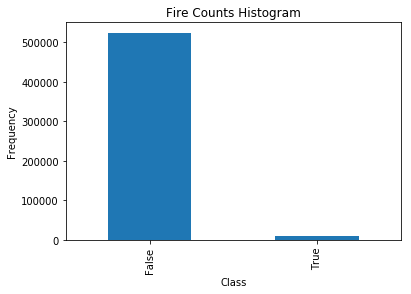

In [13]:
y_train = data_train['IS_FIRE']

pd.value_counts(y_train).plot.bar()
plt.title('Fire Counts Histogram')
plt.xlabel('Class')
plt.ylabel('Frequency')
y_train.value_counts()

# OneHotEncoding

In [75]:
data_train_x = data_train.drop(['IS_FIRE'], axis=1)
data_train_x['Month'] = data_train_x['Month'].astype(object)
data_train_x['DayOfWeek'] = data_train_x['DayOfWeek'].astype(object)
data_train_x['TIME_BUCKET'] = data_train_x['TIME_BUCKET'].astype(object)
X_train = pd.get_dummies(data_train_x)
X_train.head()

,Weekend,Holiday,Mean Temp (°C),Heat Deg Days (°C),Cool Deg Days (°C),Month_1,Month_2,Month_3,Month_4,Month_5,Month_6,Month_7,Month_8,Month_9,Month_10,Month_11,Month_12,DayOfWeek_0,DayOfWeek_1,DayOfWeek_2,DayOfWeek_3,DayOfWeek_4,DayOfWeek_5,DayOfWeek_6,TIME_BUCKET_0,TIME_BUCKET_1,TIME_BUCKET_2,TIME_BUCKET_3,TIME_BUCKET_4,TIME_BUCKET_5,TIME_BUCKET_6,TIME_BUCKET_7,TIME_BUCKET_8,NOM_ARROND_Ahuntsic / Cartierville,NOM_ARROND_Anjou,NOM_ARROND_Baie d'Urfé,NOM_ARROND_Beaconsfield,NOM_ARROND_Côte St-Luc,NOM_ARROND_Côte-des-Neiges / Notre-Dame-de-Grâce,NOM_ARROND_Dollard-des-Ormeaux,NOM_ARROND_Dorval,NOM_ARROND_Hampstead,NOM_ARROND_Ile Dorval,NOM_ARROND_Indéterminé,NOM_ARROND_Kirkland,NOM_ARROND_L'Ile-Bizard / Ste-Geneviève,NOM_ARROND_Lachine,NOM_ARROND_Lasalle,NOM_ARROND_Mercier / Hochelaga-Maisonneuve,NOM_ARROND_Mont-Royal,NOM_ARROND_Montréal-Est,NOM_ARROND_Montréal-Nord,NOM_ARROND_Montréal-Ouest,NOM_ARROND_Outremont,NOM_ARROND_Pierrefonds / Roxboro,NOM_ARROND_Plateau Mont-Royal,NOM_ARROND_Pointe-Claire,NOM_ARROND_Rivière-des-Prairies / Pointe-aux-Trembles,NOM_ARROND_Rosemont / Petite-Patrie,NOM_ARROND_Saint-Laurent,NOM_ARROND_Saint-Léonard,NOM_ARROND_Senneville,NOM_ARROND_Ste-Anne-de-Bellevue,NOM_ARROND_Sud-Ouest,NOM_ARROND_Verdun,NOM_ARROND_Ville-Marie,NOM_ARROND_Villeray / St-Michel / Parc Extension,NOM_ARROND_Westmount
0,True,False,-11.5,29.5,0.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
1,True,False,-11.5,29.5,0.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
2,True,False,-11.5,29.5,0.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
3,True,False,-11.5,29.5,0.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
4,True,False,-11.5,29.5,0.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0


In [0]:
# from sklearn.preprocessing import LabelEncoder
# from sklearn.preprocessing import OneHotEncoder
# 
# labelencoder = LabelEncoder()
# arrond_df = pd.DataFrame(labelencoder.fit_transform(data_train['NOM_ARROND']))
# 
# onehotencoder = OneHotEncoder()
# arrond_df = pd.DataFrame(onehotencoder.fit_transform(arrond_df).toarray())
# X_train = pd.concat([arrond_df, data_train[['Month','Day','TIME_BUCKET', 'count']]], axis=1)
# X_train.head()

In [77]:
interventions_df['Month'].unique()

array([ 1,  6,  7,  2,  8,  9, 11, 12,  3, 10,  5,  4])

In [79]:
data_train_x.head()

,Month,DayOfWeek,Weekend,Holiday,TIME_BUCKET,NOM_ARROND,Mean Temp (°C),Heat Deg Days (°C),Cool Deg Days (°C)
0,1,5,True,False,7,Sud-Ouest,-11.5,29.5,0.0
1,1,5,True,False,8,Saint-Léonard,-11.5,29.5,0.0
2,1,5,True,False,8,Villeray / St-Michel / Parc Extension,-11.5,29.5,0.0
3,1,5,True,False,8,Villeray / St-Michel / Parc Extension,-11.5,29.5,0.0
4,1,5,True,False,8,Plateau Mont-Royal,-11.5,29.5,0.0


# Applying SMOTE for oversampling

In [0]:
from imblearn.over_sampling import SMOTENC

data_train_x = data_train.drop(['IS_FIRE'], axis=1)
smote = SMOTENC(sampling_strategy='minority', categorical_features=[0,1,4,5])
X_sm, y_sm = smote.fit_sample(data_train_x, y_train)
X = X_sm
y = y_sm

True     524995
False    524995
dtype: int64

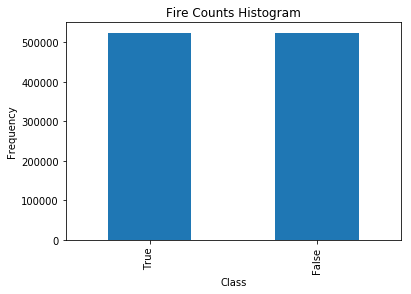

In [22]:
pd.value_counts(y_sm).plot.bar()
plt.title('Fire Counts Histogram')
plt.xlabel('Class')
plt.ylabel('Frequency')
pd.value_counts(y_sm)

In [0]:
from google.colab import files

smoted_df = pd.DataFrame(X_sm, columns=['Month', 'DayOfWeek', 'Weekend', 'Holiday', 'TIME_BUCKET', 'NOM_ARROND', 'Mean Temp', 'Heat Deg Days', 'Cool Deg Days'])
smoted_df['IS_FIRE'] = y_sm

smoted_df.to_csv('fire-weather-interventions.csv')
files.download('fire-weather-interventions.csv') 

In [23]:
smoted_df.head()

,Month,DayOfWeek,Weekend,Holiday,TIME_BUCKET,NOM_ARROND,Mean Temp,Heat Deg Days,Cool Deg Days,IS_FIRE
0,1,5,1,0,7,Sud-Ouest,-11.5,29.5,0,False
1,1,5,1,0,8,Saint-Léonard,-11.5,29.5,0,False
2,1,5,1,0,8,Villeray / St-Michel / Parc Extension,-11.5,29.5,0,False
3,1,5,1,0,8,Villeray / St-Michel / Parc Extension,-11.5,29.5,0,False
4,1,5,1,0,8,Plateau Mont-Royal,-11.5,29.5,0,False


# Data no longer imbalanced

# Training multiple classifiers

In [0]:
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.naive_bayes import GaussianNB

In [0]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X_sm, y_sm, test_size=0.2)

In [0]:
#X_sm['ind_all'] = (pd.DataFrame(X_sm).iloc[:, 5:16] == 1).idxmax(1)
pd.DataFrame(X_sm).iloc[:, 5:17].head()

In [0]:
X_train.shape

In [0]:
sgd = linear_model.SGDClassifier(max_iter=5, tol=None)
sgd.fit(X_train, Y_train)
Y_pred = sgd.predict(X_test)

sgd.score(X_train, Y_train)

acc_sgd = round(sgd.score(X_train, Y_train) * 100, 2)
acc_sgd_test = round(sgd.score(X_test, Y_test) * 100, 2)

In [0]:
random_forest = RandomForestClassifier(n_estimators=100)
random_forest.fit(X_train, Y_train, )

Y_prediction = random_forest.predict(X_test)

random_forest.score(X_train, Y_train)
acc_random_forest = round(random_forest.score(X_train, Y_train) * 100, 2)
acc_random_forest_test = round(random_forest.score(X_test, Y_test) * 100, 2)

In [0]:
logreg = LogisticRegression()
logreg.fit(X_train, Y_train)

Y_pred = logreg.predict(X_test)

acc_log = round(logreg.score(X_train, Y_train) * 100, 2)
acc_log_test = round(logreg.score(X_test, Y_test) * 100, 2)

In [0]:
# knn = KNeighborsClassifier(n_neighbors = 2) 
# knn.fit(X_train, Y_train)  
# Y_pred = knn.predict(X_test)  
# acc_knn = round(knn.score(X_train, Y_train) * 100, 2)

In [0]:
gaussian = GaussianNB() 
gaussian.fit(X_train, Y_train)  
Y_pred = gaussian.predict(X_test)  
acc_gaussian = round(gaussian.score(X_train, Y_train) * 100, 2)
acc_gaussian_test = round(gaussian.score(X_test, Y_test) * 100, 2)

In [0]:
linear_svc = LinearSVC()
linear_svc.fit(X_train, Y_train)

Y_pred = linear_svc.predict(X_test)

acc_linear_svc = round(linear_svc.score(X_train, Y_train) * 100, 2)
acc_linear_svc_test = round(linear_svc.score(X_test, Y_test) * 100, 2)

In [0]:
decision_tree = DecisionTreeClassifier() 
decision_tree.fit(X_train, Y_train)  
Y_pred = decision_tree.predict(X_test)  
acc_decision_tree = round(decision_tree.score(X_train, Y_train) * 100, 2)
acc_decision_tree_test = round(decision_tree.score(X_test, Y_test) * 100, 2)

In [0]:
perceptron = Perceptron(max_iter=5)
perceptron.fit(X_train, Y_train)

Y_pred = perceptron.predict(X_test)

acc_perceptron = round(perceptron.score(X_train, Y_train) * 100, 2)
acc_perceptron_test = round(perceptron.score(X_test, Y_test) * 100, 2)

# Comparing performance

In [0]:
results = pd.DataFrame({
    'Model': ['Support Vector Machines', 'Logistic Regression', 
              'Random Forest', 'Naive Bayes', 'Perceptron', 
              'Stochastic Gradient Decent', 
              'Decision Tree'],
    'Training Score': [acc_linear_svc, acc_log, 
              acc_random_forest, acc_gaussian, acc_perceptron, 
              acc_sgd, acc_decision_tree],
    'Testing Score': [acc_linear_svc_test, acc_log_test, 
              acc_random_forest_test, acc_gaussian_test, acc_perceptron_test, 
              acc_sgd_test, acc_decision_tree_test]})
result_df = results.sort_values(by='Testing Score', ascending=False)
result_df = result_df.set_index('Testing Score')
result_df.head(9)

# Performing K-Fold Cross Validation on Random Forest Model

In [0]:
from sklearn.model_selection import cross_val_score
rf = RandomForestClassifier(n_estimators=100)
scores = cross_val_score(rf, X_train, Y_train, cv=10, scoring = "accuracy")
print("Scores:", scores)
print("Mean:", scores.mean())
print("Standard Deviation:", scores.std())

Model has an average of 90% accuracy with 0.2% of standard deviation

# Confusion Matrix

In [0]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
predictions = cross_val_predict(random_forest, X_train, Y_train, cv=3)
confusion_matrix(Y_train, predictions)

# Precision, Recall, and F1 Score

In [0]:
from sklearn.metrics import precision_score, recall_score, f1_score

print("Precision:", precision_score(Y_train, predictions))
print("Recall:",recall_score(Y_train, predictions))
print("F1 Score:", f1_score(Y_train, predictions))

# Precision / Recall Curve to identify Best Threshold

In [0]:
from sklearn.metrics import precision_recall_curve

# getting the probabilities of our predictions
y_scores = random_forest.predict_proba(X_train)
y_scores = y_scores[:,1]

precision, recall, threshold = precision_recall_curve(Y_train, y_scores)
def plot_precision_and_recall(precision, recall, threshold):
    plt.plot(threshold, precision[:-1], "r-", label="precision", linewidth=5)
    plt.plot(threshold, recall[:-1], "b", label="recall", linewidth=5)
    plt.xlabel("threshold", fontsize=19)
    plt.legend(loc="upper right", fontsize=19)
    plt.ylim([0, 1])

plt.figure(figsize=(14, 7))
plot_precision_and_recall(precision, recall, threshold)
plt.show()

# ROC Curve

In [0]:
from sklearn.metrics import roc_curve
# compute true positive rate and false positive rate
false_positive_rate, true_positive_rate, thresholds = roc_curve(Y_train, y_scores)
# plotting them against each other
def plot_roc_curve(false_positive_rate, true_positive_rate, label=None):
    plt.plot(false_positive_rate, true_positive_rate, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'r', linewidth=4)
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate (FPR)', fontsize=16)
    plt.ylabel('True Positive Rate (TPR)', fontsize=16)

plt.figure(figsize=(14, 7))
plot_roc_curve(false_positive_rate, true_positive_rate)
plt.show()

In [0]:
from sklearn.metrics import roc_auc_score
r_a_score = roc_auc_score(Y_train, y_scores)
print("ROC-AUC-Score:", r_a_score)

# Predicting Fire Probability 

In [0]:
#borough_pred = 'Rivière-des-Prairies / Pointe-aux-Trembles'
#month_pred = 1
#day_pred = 2
#time_bucket_pred = 8
#count_pred = 10
#data_train_x_for_pred = data_train_x.append([{'Month':month_pred, 'DayOfWeek':day_pred, 'TIME_BUCKET': time_bucket_pred, 'NOM_ARROND':borough_pred, 'count': count_pred}], ignore_index=False)
#index_pred = data_train_x.last_valid_index() + 1
#index_pred

In [0]:
#X_train_for_pred = pd.get_dummies(data_train_x_for_pred)

In [0]:
#X_train_for_pred.iloc[index_pred]

In [0]:
#random_forest.predict_proba(pd.DataFrame(X_train_for_pred.iloc[index_pred]).T)

In [0]:
from sklearn.metrics import roc_curve, auc

max_depths = np.linspace(1, 32, 32, endpoint=True)
train_results = []
test_results = []
for max_depth in max_depths:
   rf = RandomForestClassifier(max_depth=max_depth, n_jobs=-1)
   rf.fit(X_train, Y_train)
   train_pred = rf.predict(X_train)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(Y_train, train_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   train_results.append(roc_auc)
   y_pred = rf.predict(X_test)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(Y_test, Y_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   test_results.append(roc_auc)
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(max_depths, train_results, 'b', label="Train AUC")
line2, = plt.plot(max_depths, test_results, 'r', label="Test AUC")
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('Tree depth')
plt.show()

In [0]:
min_samples_splits = np.linspace(0.1, 1.0, 10, endpoint=True)
train_results = []
test_results = []
for min_samples_split in min_samples_splits:
   rf = RandomForestClassifier(min_samples_split=min_samples_split)
   rf.fit(X_train, Y_train)
   train_pred = rf.predict(X_train)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(Y_train, train_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   train_results.append(roc_auc)
   y_pred = rf.predict(X_test)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(Y_test, y_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   test_results.append(roc_auc)
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(min_samples_splits, train_results, 'b', label="Train AUC")
line2, = plt.plot(min_samples_splits, test_results, 'r', label="Test AUC")
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('min samples split')
plt.show()

In [0]:
min_samples_leafs = np.linspace(0.01, 0.5, 15, endpoint=True)
train_results = []
test_results = []
for min_samples_leaf in min_samples_leafs:
   rf = RandomForestClassifier(min_samples_leaf=min_samples_leaf)
   rf.fit(X_train, Y_train)
   train_pred = rf.predict(X_train)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(Y_train, train_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   train_results.append(roc_auc)
   y_pred = rf.predict(X_test)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(Y_test, y_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   test_results.append(roc_auc)
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(min_samples_leafs, train_results, 'b', label="Train AUC")
line2, = plt.plot(min_samples_leafs, test_results, 'r', label="Test AUC")
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('min samples leaf')
plt.show()

In [0]:
max_features = list(range(1,X_sm.shape[1]))
train_results = []
test_results = []
for max_feature in max_features:
   rf = RandomForestClassifier(max_features=max_feature)
   rf.fit(X_train, Y_train)
   train_pred = rf.predict(X_train)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(Y_train, train_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   train_results.append(roc_auc)
   y_pred = rf.predict(X_test)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(Y_test, y_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   test_results.append(roc_auc)
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(max_features, train_results, 'b', label="Train AUC")
line2, = plt.plot(max_features, test_results, 'r', label="Test AUC")
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('max features')
plt.show()
